In [71]:
import pandas as pd

In [83]:
# Загрузка данных о времени регистрации
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-zakorko/shared/problem1-reg_data.csv',sep=';')

# Загрузка данных о времени захода пользователей в игру
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-zakorko/shared/problem1-auth_data.csv',sep=';')

Просмотрим загруженные нами данные

In [73]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [74]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Видим что данные представленны в виде временных меток, преобразуем их в даты

In [86]:
from datetime import datetime, timedelta
reg_data['reg_date'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date
auth_data['auth_date'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date

In [76]:
reg_data,auth_data

(            reg_ts      uid    reg_date
 0        911382223        1  1998-11-18
 1        932683089        2  1999-07-22
 2        947802447        3  2000-01-13
 3        959523541        4  2000-05-28
 4        969103313        5  2000-09-16
 ...            ...      ...         ...
 999995  1600874034  1110618  2020-09-23
 999996  1600874086  1110619  2020-09-23
 999997  1600874139  1110620  2020-09-23
 999998  1600874191  1110621  2020-09-23
 999999  1600874244  1110622  2020-09-23
 
 [1000000 rows x 3 columns],
             auth_ts      uid   auth_date
 0         911382223        1  1998-11-18
 1         932683089        2  1999-07-22
 2         932921206        2  1999-07-25
 3         933393015        2  1999-07-31
 4         933875379        2  1999-08-05
 ...             ...      ...         ...
 9601008  1600874034  1110618  2020-09-23
 9601009  1600874086  1110619  2020-09-23
 9601010  1600874139  1110620  2020-09-23
 9601011  1600874191  1110621  2020-09-23
 9601012  16008

Выполним проверку на пустые строки

In [84]:
reg_data.isnull().sum()

reg_ts    0
uid       0
dtype: int64

In [85]:
auth_data.isnull().sum()

auth_ts    0
uid        0
dtype: int64

Далее напишем функцию для подсчета Retention

In [69]:
from datetime import datetime, timedelta

def calculate_retention(reg_data, auth_data):
    
    # Слияние данных о регистрации и заходах по uid
    merged_data = pd.merge(auth_data, reg_data, on='uid')
    
    # Вычисление разницы в днях между заходом и регистрацией
    merged_data['days_since_reg'] = (merged_data['auth_date'] - merged_data['reg_date']).dt.days
    
    # Подсчет retention по дням
    retention = (merged_data.groupby('days_since_reg')['uid'].nunique() / reg_data['uid'].nunique())*100
    
    return retention.reset_index().rename(columns={'uid': 'retention_rate'})

In [70]:
# Вызов функции
retention=calculate_retention(reg_data, auth_data)

In [45]:
retention

,days_since_reg,retention_rate
0,0,100.0000
1,1,2.0071
2,2,4.0997
3,3,4.6338
4,4,5.2258
...,...,...
5911,7716,0.0001
5912,7720,0.0001
5913,7721,0.0001
5914,7727,0.0001


Для более наглядной картины давайте визуализируем наши данные

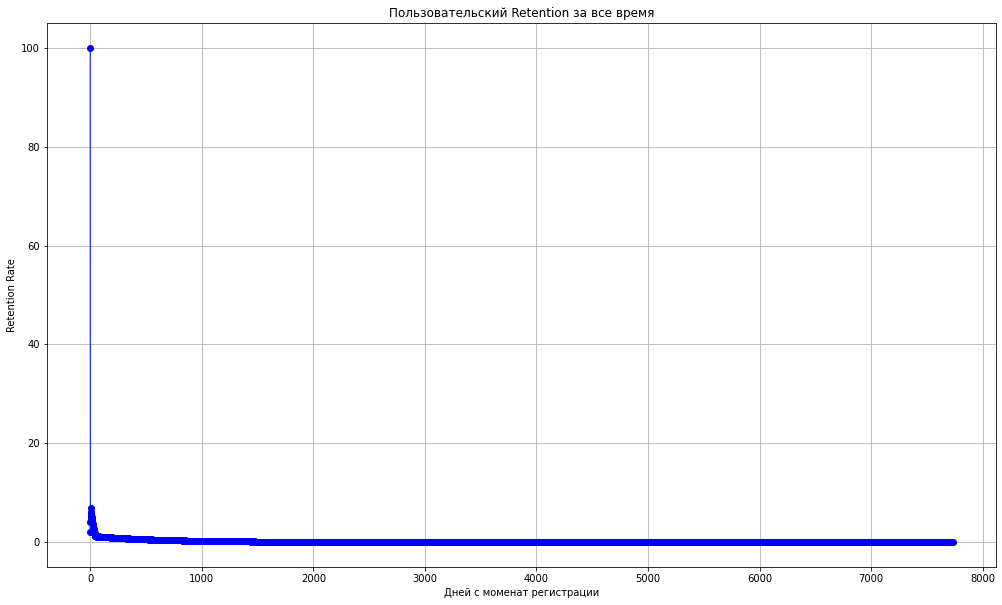

In [50]:
import matplotlib.pyplot as plt
# Построение графика
plt.figure(figsize=(17, 10))
plt.plot(retention['days_since_reg'], retention['retention_rate'], marker='o', linestyle='-', color='blue', linewidth=1)
plt.title('Пользовательский Retention за все время')
plt.xlabel('Дней с моменат регистрации')
plt.ylabel('Retention Rate')
plt.grid(True)
plt.show()


# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [79]:
# Загрузим данные
ab_test_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-zakorko/Проект_1_Задание_2.csv', sep=';')

# Проверим структуру данных
ab_test_data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [80]:
# Разделим данные на две группы: 'a' (контрольная) и 'b' (тестовая)
group_a = ab_test_data[ab_test_data['testgroup'] == 'a']
group_b = ab_test_data[ab_test_data['testgroup'] == 'b']

In [81]:
# Рассчитаем ARPU для каждой группы
arpu_a = group_a['revenue'].sum() / len(group_a)
arpu_b = group_b['revenue'].sum() / len(group_b)

# Рассчитаем Conversion Rate для каждой группы
conversion_rate_a = group_a[group_a['revenue'] > 0]['user_id'].nunique() / len(group_a)
conversion_rate_b = group_b[group_b['revenue'] > 0]['user_id'].nunique() / len(group_b)

# Рассчитаем ARPPU для каждой группы
arppu_a = group_a['revenue'].sum() / group_a[group_a['revenue'] > 0]['user_id'].nunique() if conversion_rate_a > 0 else 0
arppu_b = group_b['revenue'].sum() / group_b[group_b['revenue'] > 0]['user_id'].nunique() if conversion_rate_b > 0 else 0

# Выведем рассчитанные метрики для сравнения
metrics = pd.DataFrame({
    'Metric': ['ARPU', 'Conversion Rate', 'ARPPU'],
    'Group A': [arpu_a, conversion_rate_a, arppu_a],
    'Group B': [arpu_b, conversion_rate_b, arppu_b]
})

metrics

,Metric,Group A,Group B
0,ARPU,25.413720,26.751287
1,Conversion Rate,0.009540,0.008906
2,ARPPU,2663.998444,3003.658172


Для проведения A/B тестирования мы уже имеем результаты эксперимента в виде набора данных, в котором есть информация о двух группах: контрольной (A) и тестовой (B). Нам необходимо узнать, являются ли наблюдаемые различия в ARPU и Conversion Rate статистически значимыми.

Для этого будем использовать следующие статистические тесты:

t-тест: для сравнения средних значений ARPU между двумя группами.
    
z-тест для пропорций: для сравнения долей платящих пользователей (Conversion Rate) между двумя группами.

In [82]:
from scipy import stats
import numpy as np

# Вычисление p-значения для t-теста ARPU между двумя группами
t_stat, p_value_arpu = stats.ttest_ind(group_a['revenue'], group_b['revenue'], equal_var=False)

# Вычисление p-значения для z-теста Conversion Rate между двумя группами
from statsmodels.stats.proportion import proportions_ztest

# Количество успехов (платящих пользователей) в каждой группе
successes = np.array([group_a[group_a['revenue'] > 0]['user_id'].nunique(),
                      group_b[group_b['revenue'] > 0]['user_id'].nunique()])

# Количество наблюдений в каждой группе
nobs = np.array([len(group_a), len(group_b)])

# z-тест для пропорций
z_stat, p_value_conv = proportions_ztest(successes, nobs)

(p_value_arpu, p_value_conv)


(0.5329647014130866, 0.035028524642854865)

# Результаты статистического анализа следующие:

p-значение для t-теста ARPU составляет примерно 0.533. Это означает, что при уровне значимости 0.05 мы не можем отклонить нулевую гипотезу о том, что средние значения ARPU в группах A и B равны. Различия в ARPU между группами статистически не значимы.

p-значение для z-теста Conversion Rate составляет примерно 0.035. Это значение меньше 0.05, что позволяет нам отклонить нулевую гипотезу о том, что доли платящих пользователей в группах A и B равны. Следовательно, различие в Conversion Rate между группами статистически значимо.

# На основе этих моментов:

Если целью компании является максимизация среднего дохода от всех пользователей, то можно выбрать группу B, несмотря на меньшую конверсию, так как ARPU не отличается значимо, а ARPPU выше.

Если важно привлечение как можно большего числа платящих пользователей, то стоит остановиться на группе A, так как она показала более высокую конверсию.

# Вывод:
На основе текущих данных, можно сделать вывод о том, что группа B с более высоким ARPPU и сопоставимым ARPU, несмотря на меньший Conversion Rate, может более выгодная с точки зрения доходности в краткосрочной перспективе для компании чем группа А.

# Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Во-первых как главные метрики я бы выделил:

1.Число участников события(Сколько уникальных игроков участвовало в событии).

2.Среднее время, проведенное в событии(Сколько времени в среднем игроки проводят в событии).

Во-вторых компании нельзя забывать о прибыли, так как все нововедения в играх требуют не маленьких затрат, именно поэтому второстепенной метрикой будет выступать Монетизация:ARPU во время события(Средний доход на пользователя за период события) или Покупки внутри события(Количество и сумма покупок, совершенных игроками во время события).

И наконец мы должны оценить какой Retencion rate присутсвует в нашей игре во время данного события.

По поводу усложненного события можно будет оставить прошлые метрики, но при этом мы должны будем добавить ряд новых метрик, такие как:

1.Повторное прохождение уровней: количество раз, которое игрокам приходилось повторно проходить уровни из-за неудачных попыток, что покажет уровень сложности и возможные места "застревания" (данная метрика интрпретируется как CR, тоесть мы должны проанализировать на каких уровнях игроки могут застревать и не проходить на следующий шаг, соотвественно после большого количества неудачных прохождений можно будет предлогать пользователям всяческие внутриигровые покупки или улучшения что может повысить наш ARPU. Прохождение игроков до конца, в свою очередь, будет сбособствовать увелечению retenthion и положительных отзывов об игре и из этого пункта у нас следует пункт №2).

2.Обратная связь по измененной механике: анализ отзывов игроков поможет понять, как нововведение было принято аудиторией и что можно улучшить в дальнейшем.